# 医院销售数据分析

假设以某医院2018年销售数据为例，目的是了解朝阳医院在2018年里的销售情况，这就需要知道几个业务指标，例如：月均消费次数，月均消费金额、客单价以及消费趋势。

- 先导入包，然后读取数据，读取的时候用Object读取，防止有些数据读不了：

In [3]:
import pandas as pd

# 读取数据
data = pd.read_excel("./data/朝阳医院2018年销售数据.xlsx", dtype="object")

# 转换成DataFrame格式
dataDF = pd.DataFrame(data)

dataDF.head()

,购药时间,社保卡号,商品编码,商品名称,销售数量,应收金额,实收金额
0,2018-01-01 星期五,001616528,236701,强力VC银翘片,6,82.8,69
1,2018-01-02 星期六,001616528,236701,清热解毒口服液,1,28,24.64
2,2018-01-06 星期三,0012602828,236701,感康,2,16.8,15
3,2018-01-11 星期一,0010070343428,236701,三九感冒灵,1,28,28
4,2018-01-15 星期五,00101554328,236701,三九感冒灵,8,224,208


- 查看数据集基本的信息

In [4]:
# 查看数据几行几列
dataDF.shape

# 查看索引
dataDF.index

# 查看每一列的列表头内容
dataDF.columns

# 查看每一列的数据统计数目
dataDF.count()

购药时间    6576
社保卡号    6576
商品编码    6577
商品名称    6577
销售数量    6577
应收金额    6577
实收金额    6577
dtype: int64

总共有6578行7列数据，但是“购药时间”和“社保卡号”这两列只有6576个数据，而“商品编码”到“实收金额”这些列都是只有6577个数据，这就意味着数据中存在缺失值，可以推断出数据中存在一行缺失值，此外“购药时间”和“社保卡号”这两列都各自存在一个缺失数据，这些缺失数据在后面步骤中需要进一步处理。

### 列名重命名

In [6]:
# 使用 rename 函数，把"购药时间" 改为 "销售时间
dataDF.rename(columns={"购药时间": "销售时间"}, inplace=True)
dataDF.columns

Index(['销售时间', '社保卡号', '商品编码', '商品名称', '销售数量', '应收金额', '实收金额'], dtype='object')

### 缺失数据处理

In [7]:
# 处理之前
dataDF.shape # 6578行7列

# 使用dropna删除缺失值
dataDF = dataDF.dropna()

# 删除缺失值之后
dataDF.shape

(6575, 7)

在导入数据时为了防止导入不进来，会强制所有数据都是object类型，但实际数据分析过程中“销售数量”，“应收金额”，“实收金额”，这些列需要浮点型（float）数据，“销售时间”需要改成时间格式，因此需要对数据类型进行转换。

In [8]:
# 使用astype()函数转为浮点型数据
dataDF["销售数量"] = dataDF["销售数量"].astype("f8")
dataDF["应收金额"] = dataDF["应收金额"].astype("f8")
dataDF["实收金额"] = dataDF["实收金额"].astype("f8")

dataDF.dtypes

销售时间     object
社保卡号     object
商品编码     object
商品名称     object
销售数量    float64
应收金额    float64
实收金额    float64
dtype: object

在“销售时间”这一列数据中存在星期这样的数据，但在数据分析过程中不需要用到，因此要把销售时间列中日期和星期使用split函数进行分割，分割后的时间，返回的是Series数据类型：

In [10]:
# 定义函数将星期去除
def splitsaletime(timeColser):
    timelist = []
    for t in timeColser:
        timelist.append(t.split(" ")[0])  # [0]表示选取的分片，这里表示切割完后选取第一个分片
    timeser = pd.Series(timelist)  # 将列表转行为一维数据Series类型
    return timeser
 
# 获取"销售时间"这一列数据
t = dataDF.loc[:, "销售时间"]

# 调用函数去除星期，获取日期
timeser = splitsaletime(t)

# 修改"销售时间"这一列日期
dataDF.loc[:, "销售时间"] = timeser

dataDF.head()

,销售时间,社保卡号,商品编码,商品名称,销售数量,应收金额,实收金额
0,2018-01-01,001616528,236701,强力VC银翘片,6.0,82.8,69.00
1,2018-01-02,001616528,236701,清热解毒口服液,1.0,28.0,24.64
2,2018-01-06,0012602828,236701,感康,2.0,16.8,15.00
3,2018-01-11,0010070343428,236701,三九感冒灵,1.0,28.0,28.00
4,2018-01-15,00101554328,236701,三九感冒灵,8.0,224.0,208.00


接着把切割后的日期转为时间格式，方便后面的数据统计：

In [12]:
# 字符串转日期
# errors='coerce'如果原始数据不符合日期的格式，转换后的值为NaT
dataDF.loc[:, "销售时间"] = pd.to_datetime(dataDF.loc[:, "销售时间"], errors='coerce')
dataDF.dtypes

销售时间    datetime64[ns]
社保卡号            object
商品编码            object
商品名称            object
销售数量           float64
应收金额           float64
实收金额           float64
dtype: object

In [13]:
# 转换日期的过程中不符合日期格式的数值会被转换成空值None
# 这里删除为空的行
dataDF = dataDF.dropna()
dataDF.shape

(6549, 7)

### 数据排序

此时时间是没有按顺序排列的，所以还是需要排序一下，排序之后索引会被打乱，所以也需要重置一下索引。其中by:表示按哪一列进行排序，ascending=True表示升序排列，ascending=False表示降序排列：

In [19]:
# 按销售时间进行排序
dataDF = dataDF.sort_values(by='销售时间', ascending=True)
dataDF.head()

,销售时间,社保卡号,商品编码,商品名称,销售数量,应收金额,实收金额
1190,2018-01-01,0010073966328,861409,非洛地平缓释片(波依定),5.0,162.5,145.0
399,2018-01-01,0010074599128,2367011,开博通,5.0,140.0,125.0
5774,2018-01-01,0013169628,861462,珍菊降压片,1.0,9.5,8.5
398,2018-01-01,0010072612028,2367011,开博通,1.0,28.0,25.0
1306,2018-01-01,001616528,861417,雷米普利片(瑞素坦),1.0,28.5,28.5


In [21]:
# 重置索引(index)
dataDF = dataDF.reset_index(drop=True)
dataDF.head()

,销售时间,社保卡号,商品编码,商品名称,销售数量,应收金额,实收金额
0,2018-01-01,0010073966328,861409,非洛地平缓释片(波依定),5.0,162.5,145.0
1,2018-01-01,0010074599128,2367011,开博通,5.0,140.0,125.0
2,2018-01-01,0013169628,861462,珍菊降压片,1.0,9.5,8.5
3,2018-01-01,0010072612028,2367011,开博通,1.0,28.0,25.0
4,2018-01-01,001616528,861417,雷米普利片(瑞素坦),1.0,28.5,28.5


### 异常值处理

In [22]:
# 查看描述统计信息
dataDF.describe()

,销售数量,应收金额,实收金额
count,6549.000000,6549.000000,6549.000000
mean,2.384486,50.449076,46.284370
std,2.375227,87.696401,81.058426
min,-10.000000,-374.000000,-374.000000
25%,1.000000,14.000000,12.320000
50%,2.000000,28.000000,26.500000
75%,2.000000,59.600000,53.000000
max,50.000000,2950.000000,2650.000000


通过描述统计信息可以看到，“销售数量”、“应收金额”、“实收金额”这三列数据的最小值出现了负数，这明显不符合常理，数据中存在异常值的干扰，因此要对数据进一步处理，以排除异常值的影响：

In [23]:
# 将‘销售数量’这一列中小于0的数排除掉
pop = dataDF.loc[:, "销售数量"] > 0
dataDF = dataDF.loc[pop, :]

# 排出一场之后再次查看描述统计信息
dataDF.describe()

,销售数量,应收金额,实收金额
count,6506.000000,6506.000000,6506.000000
mean,2.405626,50.927897,46.727653
std,2.364565,87.650282,80.997726
min,1.000000,1.200000,0.030000
25%,1.000000,14.000000,12.600000
50%,2.000000,28.000000,27.000000
75%,2.000000,59.600000,53.000000
max,50.000000,2950.000000,2650.000000


### 业务指标1：月均消费次数


月均消费次数 = 总消费次数 / 月份数



1、计算总消费次数

同一天内，同一个人发生的所有消费算作一次消费

In [25]:
# 删除重复数据
kpi1_Df = dataDF.drop_duplicates(subset=['销售时间', '社保卡号'])

# # 删除重复数据 
# kpi1_Df = dataDF.drop_duplicates(subset=['销售时间', '社保卡号'])

# 有多少行
totall = kpi1_Df.shape[0]
print("总消费数据：", totall)

总消费数据： 5342


2、计算月份数

In [26]:
# 按销售时间升序排序
kpi1_Df = kpi1_Df.sort_values(by='销售时间', ascending=True)

# 重命名行名(index)
kpi1_Df = kpi1_Df.reset_index(drop=True)

# 获取时间范围
# 最小时间值
startTime = kpi1_Df.loc[0, '销售时间']
# 最大时间值
endTime = kpi1_Df.loc[totall - 1, '销售时间']

# 计算天数
daysI = (endTime - startTime).days

# 月份数：运算符"//"表示取整除，返回商的整数部分,假设按一个月30天去计算！
monthsI = daysI // 30
print("月份数：", monthsI)

月份数： 6


3、计算月均消费

In [30]:
# 计算月均消费
kpi1_I = totall // monthsI
print('业务指标1,: 月均消费次数：', kpi1_I)

业务指标1,: 月均消费次数： 890


### 业务指标2：月均消费金额

月均消费金额 = 总消费金额 / 月份数

In [29]:
# 总消费金额
totalMoneyF = dataDF.loc[:, '实收金额'].sum()

# 月均消费金额
monthMoneyF = totalMoneyF / monthsI
print('业务指标2：月均消费金额 =  ', monthMoneyF)

业务指标2：月均消费金额 =   50668.35166666668


### 业务指标3：客单价

客单价 = 总消费金额 / 总消费次数

In [33]:
# 客单价 = 总消费金额 / 总消费次数
pct = totalMoneyF / totall
print('业务指标3：客单价=', pct)

业务指标3：客单价= 56.90941782104082


### 业务指标4：消费趋势

In [34]:
# 先导入相关的包
import matplotlib.pyplot as plt
# 画图时用于显示中文字符
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 在操作之前先复制一份数据，防止影响清洗后的数据
groupDf = dataDF

1、分析每天的消费金额

In [36]:
# 重命名行（index）为销售时间所在列的值
groupDf.index = groupDf['销售时间']
groupDf.head()

,销售时间,社保卡号,商品编码,商品名称,销售数量,应收金额,实收金额
销售时间,,,,,,,
2018-01-01,2018-01-01,0010073966328,861409,非洛地平缓释片(波依定),5.0,162.5,145.0
2018-01-01,2018-01-01,0010074599128,2367011,开博通,5.0,140.0,125.0
2018-01-01,2018-01-01,0013169628,861462,珍菊降压片,1.0,9.5,8.5
2018-01-01,2018-01-01,0010072612028,2367011,开博通,1.0,28.0,25.0
2018-01-01,2018-01-01,001616528,861417,雷米普利片(瑞素坦),1.0,28.5,28.5


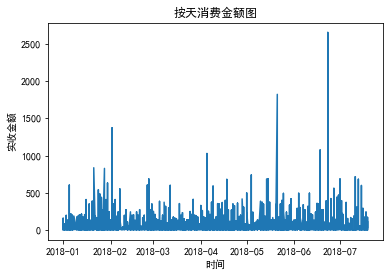

In [38]:
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
# 画图
plt.plot(groupDf['实收金额'])
plt.title('按天消费金额图')
plt.xlabel('时间')
plt.ylabel('实收金额')

 # 保存图片
plt.savefig('./day.png')
# 显示图片
plt.show()

从结果可以看出，每天消费总额差异较大，除了个别天出现比较大笔的消费，大部分人消费情况维持在500元以内。

2、分析每月的消费金额

接下来，将销售时间先聚合再按月分组进行分析：

In [39]:
# 将销售时间聚合按月分组
gb = groupDf.groupby(groupDf.index.month)
gb

In [40]:
# 应用函数，计算每个月的消费总额
monthDf = gb.sum()
monthDf

,销售数量,应收金额,实收金额
销售时间,,,
1,2527.0,53561.6,49461.19
2,1858.0,42028.8,38790.38
3,2225.0,45318.0,41597.51
4,3005.0,54296.3,48787.84
5,2225.0,51263.4,46925.27
6,2328.0,52300.8,48327.70
7,1483.0,32568.0,30120.22


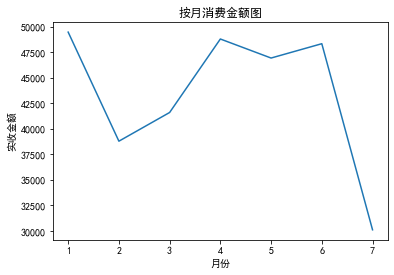

In [41]:
# 描绘按月消费金额图
plt.plot(monthDf['实收金额'])
plt.title('按月消费金额图')
plt.xlabel('月份')
plt.ylabel('实收金额')

# 保存图片
plt.savefig('./month.png')
# 显示图片
plt.show()

结果显示，7月消费金额最少，这是因为7月份的数据不完整，所以不具参考价值。

1月、4月、5月和6月的月消费金额差异不大，2月和3月的消费金额迅速降低，这可能是2月和3月处于春节期间，大部分人都回家过年的原因。

3、分析药品销售情况

对“商品名称”和“销售数量”这两列数据进行聚合为Series形式，方便后面统计，并按降序排序：



In [42]:
# 聚合统计各种药品的销售数量
medicine = groupDf[['商品名称','销售数量']]
bk = medicine.groupby('商品名称')[['销售数量']]
re_medicine = bk.sum()

# 对药品销售数量按降序排序
re_medicine = re_medicine.sort_values(by='销售数量',ascending=False)
re_medicine.head()

,销售数量
商品名称,
苯磺酸氨氯地平片(安内真),1781.0
开博通,1440.0
酒石酸美托洛尔片(倍他乐克),1140.0
硝苯地平片(心痛定),825.0
苯磺酸氨氯地平片(络活喜),796.0


截取销售数量最多的前十种药品，并用条形图展示结果：

In [43]:
# 截取销售数量最多的十种药品
top_medicine = re_medicine.iloc[:10,:]
top_medicine

,销售数量
商品名称,
苯磺酸氨氯地平片(安内真),1781.0
开博通,1440.0
酒石酸美托洛尔片(倍他乐克),1140.0
硝苯地平片(心痛定),825.0
苯磺酸氨氯地平片(络活喜),796.0
复方利血平片(复方降压片),515.0
G琥珀酸美托洛尔缓释片(倍他乐克),509.0
缬沙坦胶囊(代文),445.0
非洛地平缓释片(波依定),375.0


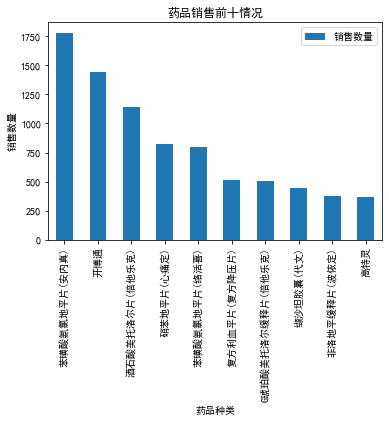

In [44]:
# 用条形图展示销售数量前十的药品
top_medicine.plot(kind='bar')
plt.title('药品销售前十情况')
plt.xlabel('药品种类')
plt.ylabel('销售数量')
plt.legend(loc=0)
 
# 保存图片
plt.savefig('./medicine.png')
# 显示图片
plt.show()

得到销售数量最多的前十种药品信息，这些信息将会有助于加强医院对药房的管理。